https://www.space-track.org/documentation#/faq

- period = 1440/n
- Using mu, the standard gravitational parameter for the earth (398600.4418),
- semi-major axis "a" = (mu/(n*2*pi/(24*3600))^2)^(1/3)
- Using semi-major axis "a", eccentricity "e", and the Earth's radius in km,
    - apogee = (a * (1 + e))- 6378.135
    - perigee = (a * (1 - e))- 6378.135

In [1]:
%load_ext autoreload
%autoreload 2

In [59]:
from sgp4.api import Satrec, jday
from doop.constants import Earth
from doop.tle import parse_tle
from doop.coe_plot import orbit

import numpy as np
from numpy import pi, sqrt, sin, cos
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

In [3]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Circle

In [4]:
# https://www.sciencedirect.com/topics/engineering/julian-day-number
jd, fr = jday(1914, 8, 14, 5, 30, 0)
print(np.isclose(jd + fr, 2420358.729))
jd, fr = jday(2010, 9, 1, 0, 0, 0)
print(np.isclose(jd + fr,2455440.500))
jd, fr = jday(2007, 10, 16, 12, 0, 0)
print(np.isclose(jd + fr, 2454390.000))

True
True
True


In [32]:
from datetime import datetime

In [33]:
datetime.now()

datetime.datetime(2020, 6, 6, 11, 50, 47, 279948)

In [34]:
# 'wgs84':
# #  ------------ wgs-84 constants ------------
# mu     = 398600.5;            #  in km3 / s2
# radiusearthkm = 6378.137;     #  km
# xke    = 60.0 / sqrt(radiusearthkm*radiusearthkm*radiusearthkm/mu);
# tumin  = 1.0 / xke;
# j2     =   0.00108262998905;
# j3     =  -0.00000253215306;
# j4     =  -0.00000161098761;
# j3oj2  =  j3 / j2;

def julian(year, mon, day, hr, minute, sec):
    """From sgp4, MIT License
    
    Return two floats that, when added, produce the specified Julian date.
    The first float returned gives the date, while the second float
    provides an additional offset for the particular hour, minute, and
    second of that date.  Because the second float is much smaller in
    magnitude it can, unlike the first float, be accurate down to very
    small fractions of a second.
    >>> jd, fr = jday(2020, 2, 11, 13, 57, 0)
    >>> jd
    2458890.5
    >>> fr
    0.58125
    Note that the first float, which gives the moment of midnight that
    commences the given calendar date, always carries the fraction
    ``.5`` because Julian dates begin and end at noon.  This made
    Julian dates more convenient for astronomers in Europe, by making
    the whole night belong to a single Julian date.
    This function is a simple translation to Python of the C++ routine
    ``jday()`` in Vallado's ``SGP4.cpp``.
    """
    jd = (367.0 * year
        - 7 * (year + ((mon + 9) // 12.0)) * 0.25 // 1.0
        + 275 * mon / 9.0 // 1.0
        + day
        + 1721013.5)
    fr = (sec + minute * 60.0 + hr * 3600.0) / 86400.0;
    return jd + fr

In [35]:
print(julian(2020, 12, 11, 24, 0, 0))
jd, fr = jday(2020, 12, 11, 0, 0, 0)
print(jd,fr)
jd, fr = jday(2020, 12, 10, 24, 0, 0)
print(jd,fr)
jd, fr = jday(2020, 12, 10, 18, 0, 0)
print(jd,fr)
jd, fr = jday(2020, 12, 10, 12, 0, 0)
print(jd,fr)
jd, fr = jday(2020, 12, 10, 6, 0, 0)
print(jd,fr)
jd, fr = jday(2020, 12, 10, 0, 0, 0)
print(jd,fr)

2459195.5
2459194.5 0.0
2459193.5 1.0
2459193.5 0.75
2459193.5 0.5
2459193.5 0.25
2459193.5 0.0


In [6]:
def plot(satellite, jul, pts=100):
    tt = satellite.nm # mean anomoly
    dt = tt/pts
    jd = jul*np.ones(pts)
    fr = np.arange(0,tt,dt)
#     print(satellite.im)

    e, r2, v = satellite.sgp4_array(jd, fr)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(f"{jul} {satellite.im} {satellite.ecco}")

    ax.plot(
        r2[:,0],
        r2[:,1],
        r2[:,2],
        color="blue",
        label="x"
    );

In [87]:
def one_orbit(sat, jul):
    tt = sat.nm # mean anomoly
    pts = 100
    dt = tt/pts
    jd = jul*np.ones(pts)
    fr = np.arange(0,tt,dt)
    e, r, v = sat.sgp4_array(jd, fr)
    return r

In [88]:
s1 = '1 25544U 98067A   19343.69339541  .00001764  00000-0  38792-4 0  9991'
t1 = '2 25544  51.6439 211.2001 0007417  17.6667  85.6398 15.50103472202482'
sat1 = Satrec.twoline2rv(s1, t1)
jd = julian(2020, 12, 11, 0, 0, 0)
r1 = one_orbit(sat1,jd)

s2 = "1 43941U 19004A   20153.89420345 0.00001200  00000-0  19028-4 0    01"
t2 = "2 43941  73.5679  68.7062 0014053 299.7954  60.2045 15.53145476    05"
sat2 = Satrec.twoline2rv(s2, t2)
r2 = one_orbit(sat2,jd)

In [89]:
def plot2(rs):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
#     ax.set_title(f"{jul} {satellite.im} {satellite.ecco}")

    for r in rs:
        ax.plot(
            r[:,0],
            r[:,1],
            r[:,2],
    #         color="blue",
    #         label="x"
        );

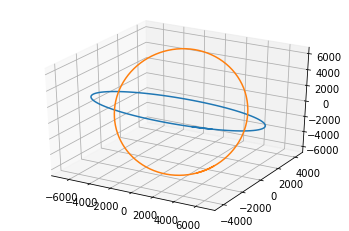

In [90]:
plot2([r1,r2])

In [10]:
def perifocal(orbit, f):
    p = orbit.am*Earth.radius * (1 - orbit.ecco ** 2)
    pos = np.array([cos(f), sin(f)]) * p / (1 + orbit.ecco * cos(f))
    return pos

In [11]:
o = []
for i in range(360):
    o.append(perifocal(satellite, i*pi/180))
    
orb = np.array(o)

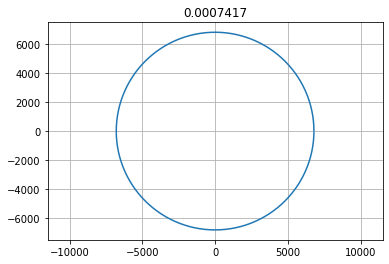

In [12]:
plt.plot(orb[:,0], orb[:,1])
plt.axis('equal')
plt.title(f"{satellite.ecco}")
plt.grid(True);

In [57]:
satellite.nm

0.06770212130671713

In [95]:
# sat = parse_tle("bob\r\n" + s + "\r\n" + t)
tle = """ISS (ZARYA)
1 25544U 98067A   19249.04864348  .00001909  00000-0  40858-4 0  9990
2 25544  51.6464 320.1755 0007999  10.9066  53.2893 15.50437522187805"""

tle="""1 41584U 16036A   20135.03964408 0.00000000  00000-0  00000-0 0    06
2 41584   6.6497 351.6663 0055793  42.4551 317.9982  1.00270000    05"""

tle2 = """1 43941U 19004A   20153.89420345 0.00001200  00000-0  19028-4 0    01
2 43941  73.5679  68.7062 0014053 299.7954  60.2045 15.53145476    05"""

# tle = """MOLNIYA 2-14            
# 1 08195U 75081A   20157.39364663 -.00000579  00000-0 -89150-3 0  9998
# 2 08195  63.0997 280.3937 7284978 292.9983   8.9095  2.02111184327955"""

tle = """USA 290/KH-11 17 3.0  2.0  0.0  5.0 d    6
1 43941U 19004A   20153.89420345 0.00001200  00000-0  19028-4 0    01
2 43941  73.5679  68.7062 0014053 299.7954  60.2045 15.53145476    05"""

# sat = parse_tle("unknown\r\n" + tle)
sat = parse_tle(tle)
sat2 = parse_tle(tle2)

In [96]:
def plot_orbit(sats):
    if not isinstance(sats, list):
        sats = [sats]
    
    plt.figure(figsize=(8,8))
    ax = plt.gca()

    for sat in sats:
        oorb = orbit(sat.coe)
        # plot orbit
        ax.plot(
            oorb[:,0], oorb[:,1], '--r',
        #     color="orange",
            label=sat.object.name,
        )

    atmos = Circle(xy=(0,0), radius=Earth.radius+600, color="blue", alpha=0.1)
    ax.add_patch(atmos)

    earth = Circle(xy=(0,0), radius=Earth.radius, color="gray")
    ax.add_patch(earth)
    ax.axis("equal")
    ax.grid(True)
    ax.legend();

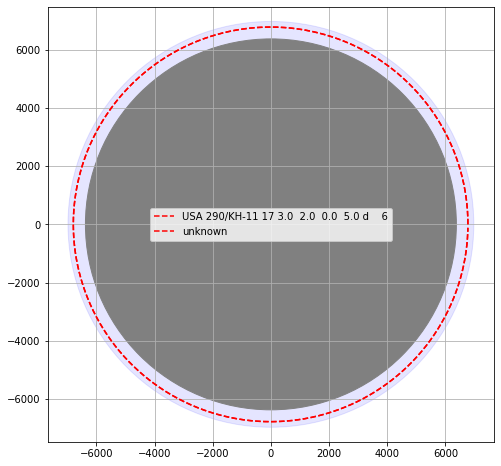

In [97]:
plot_orbit([sat, sat2])

In [94]:
j = [
    {"OBJECT_NAME":"MTI","OBJECT_ID":"2000-014A","EPOCH":"2020-06-06T14:57:56.771136","MEAN_MOTION":15.55746721,"ECCENTRICITY":0.0006022,"INCLINATION":97.5029,"RA_OF_ASC_NODE":40.2706,"ARG_OF_PERICENTER":267.7531,"MEAN_ANOMALY":92.3058,"EPHEMERIS_TYPE":0,"CLASSIFICATION_TYPE":"U","NORAD_CAT_ID":26102,"ELEMENT_SET_NO":999,"REV_AT_EPOCH":12283,"BSTAR":6.1563e-5,"MEAN_MOTION_DOT":4.136e-5,"MEAN_MOTION_DDOT":0},
    {"OBJECT_NAME":"CFESAT","OBJECT_ID":"2007-006F","EPOCH":"2020-06-06T01:03:13.436928","MEAN_MOTION":15.36659729,"ECCENTRICITY":0.000387,"INCLINATION":35.4261,"RA_OF_ASC_NODE":27.6009,"ARG_OF_PERICENTER":87.312,"MEAN_ANOMALY":272.8049,"EPHEMERIS_TYPE":0,"CLASSIFICATION_TYPE":"U","NORAD_CAT_ID":30777,"ELEMENT_SET_NO":999,"REV_AT_EPOCH":73469,"BSTAR":5.9151e-5,"MEAN_MOTION_DOT":2.117e-5,"MEAN_MOTION_DDOT":0},
    {"OBJECT_NAME":"SPIRALE A","OBJECT_ID":"2009-008C","EPOCH":"2020-06-05T21:13:54.934176","MEAN_MOTION":4.58741232,"ECCENTRICITY":0.5376455,"INCLINATION":2.0249,"RA_OF_ASC_NODE":224.4347,"ARG_OF_PERICENTER":310.6298,"MEAN_ANOMALY":13.8538,"EPHEMERIS_TYPE":0,"CLASSIFICATION_TYPE":"U","NORAD_CAT_ID":33751,"ELEMENT_SET_NO":999,"REV_AT_EPOCH":16075,"BSTAR":0.00053704,"MEAN_MOTION_DOT":7.4e-7,"MEAN_MOTION_DDOT":0},
    {"OBJECT_NAME":"SPIRALE B","OBJECT_ID":"2009-008D","EPOCH":"2020-06-06T10:11:59.398656","MEAN_MOTION":2.75814862,"ECCENTRICITY":0.6918053,"INCLINATION":1.8167,"RA_OF_ASC_NODE":148.7963,"ARG_OF_PERICENTER":86.9186,"MEAN_ANOMALY":343.5908,"EPHEMERIS_TYPE":0,"CLASSIFICATION_TYPE":"U","NORAD_CAT_ID":33752,"ELEMENT_SET_NO":999,"REV_AT_EPOCH":10444,"BSTAR":0.00041233,"MEAN_MOTION_DOT":2.329e-5,"MEAN_MOTION_DDOT":0},
    {"OBJECT_NAME":"SAPPHIRE","OBJECT_ID":"2013-009C","EPOCH":"2020-06-06T11:04:39.864000","MEAN_MOTION":14.34210175,"ECCENTRICITY":0.0010658,"INCLINATION":98.4706,"RA_OF_ASC_NODE":0.0759,"ARG_OF_PERICENTER":323.5031,"MEAN_ANOMALY":36.5426,"EPHEMERIS_TYPE":0,"CLASSIFICATION_TYPE":"U","NORAD_CAT_ID":39088,"ELEMENT_SET_NO":999,"REV_AT_EPOCH":38092,"BSTAR":1.8491e-5,"MEAN_MOTION_DOT":9.0e-8,"MEAN_MOTION_DDOT":0}]

print(f">> {len(j)} satellites found")
for i, (k, v) in enumerate(j[0].items()):
    print(f"{k}: {v}")

>> 5 satellites found
OBJECT_NAME: MTI
OBJECT_ID: 2000-014A
EPOCH: 2020-06-06T14:57:56.771136
MEAN_MOTION: 15.55746721
ECCENTRICITY: 0.0006022
INCLINATION: 97.5029
RA_OF_ASC_NODE: 40.2706
ARG_OF_PERICENTER: 267.7531
MEAN_ANOMALY: 92.3058
EPHEMERIS_TYPE: 0
CLASSIFICATION_TYPE: U
NORAD_CAT_ID: 26102
ELEMENT_SET_NO: 999
REV_AT_EPOCH: 12283
BSTAR: 6.1563e-05
MEAN_MOTION_DOT: 4.136e-05
MEAN_MOTION_DDOT: 0
